## **Amazon Sales Dataset**

**Import relevant libraries**

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tabulate import tabulate
from prettytable import PrettyTable
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import zscore
from colorama import Fore, Style, init

In [39]:
data = pd.read_excel(r"D:\Data Analytics\PortfolioProjects\Amazon Sale Report.xlsx")

In [40]:
df = data.copy()

### **Firstly lets do some data cleaning**

**Dropping all duplicates and unnecessary columns**

In [41]:
df = df.drop_duplicates()

In [42]:
df.set_index('index', inplace = True)

In [43]:
columns_to_drop = ['ship-country', 'Unnamed: 22', 'fulfilled-by', 'currency', 'Sales Channel ', 'promotion-ids', 'ASIN']
df = df.drop(columns=columns_to_drop)

**Identifying nulls and filling them**

In [44]:
df.isnull().sum()

Order ID                 0
Date                     0
Status                   0
Fulfilment               0
ship-service-level       0
Style                    0
SKU                      0
Category                 0
Size                     0
Courier Status        6872
Qty                      0
Amount                7795
ship-city               33
ship-state              33
ship-postal-code        33
B2B                      0
dtype: int64

In [45]:
df['ship-state'] = df['ship-state'].fillna('not known')
df['ship-city'] = df['ship-city'].fillna('not known')
df['ship-postal-code'] = df['ship-postal-code'].fillna('not known')
df['Courier Status'] = df['Courier Status'].fillna('not known')
df['Amount'] = df['Amount'].fillna(0)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128975 entries, 0 to 128974
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Order ID            128975 non-null  object        
 1   Date                128975 non-null  datetime64[ns]
 2   Status              128975 non-null  object        
 3   Fulfilment          128975 non-null  object        
 4   ship-service-level  128975 non-null  object        
 5   Style               128975 non-null  object        
 6   SKU                 128975 non-null  object        
 7   Category            128975 non-null  object        
 8   Size                128975 non-null  object        
 9   Courier Status      128975 non-null  object        
 10  Qty                 128975 non-null  int64         
 11  Amount              128975 non-null  float64       
 12  ship-city           128975 non-null  object        
 13  ship-state          128975 no

**Now we have no NULL Values**

In [47]:
df.columns

Index(['Order ID', 'Date', 'Status', 'Fulfilment', 'ship-service-level',
       'Style', 'SKU', 'Category', 'Size', 'Courier Status', 'Qty', 'Amount',
       'ship-city', 'ship-state', 'ship-postal-code', 'B2B'],
      dtype='object')

In [48]:
df.nunique()

Order ID              120378
Date                      91
Status                    13
Fulfilment                 2
ship-service-level         2
Style                   1377
SKU                     7195
Category                   9
Size                      11
Courier Status             4
Qty                       10
Amount                  1410
ship-city               8956
ship-state                70
ship-postal-code        9460
B2B                        2
dtype: int64

In [49]:
def apply_table_style(df):
    table_style = [
        {'selector': 'thead th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'tbody td', 'props': [('padding', '8px'), ('text-align', 'center')]},
        {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},
        {'selector': 'th', 'props': [('border', '1px solid #ddd')]},
        {'selector': 'td', 'props': [('border', '1px solid #ddd')]},
        {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', 'transparent')]},
        {'selector': 'tbody tr:hover', 'props': [('background-color', 'transparent')]}
    ]
    
    return df.style.set_table_styles(table_style)

### **Sales Trends: Analyzing how sales have been trending over time.**

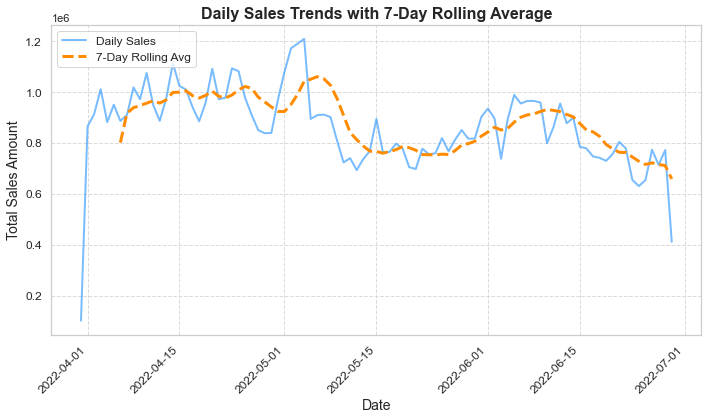

In [50]:
sns.set(style="whitegrid")

df['Date'] = pd.to_datetime(df['Date'])

df['Month'] = df['Date'].dt.strftime('%B')  
df['Day'] = df['Date'].dt.strftime('%A')    

daily_sales = df.groupby('Date')['Amount'].sum()
daily_sales_rolling = daily_sales.rolling(window=7).mean()

plt.figure(figsize=(10, 6)) 
plt.plot(daily_sales.index, daily_sales.values, label='Daily Sales', color='dodgerblue', alpha=0.6, linewidth=2)
plt.plot(daily_sales.index, daily_sales_rolling, label='7-Day Rolling Avg', color='darkorange', linestyle='--', linewidth=3)
plt.title('Daily Sales Trends with 7-Day Rolling Average', fontsize=16, fontweight='bold')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales Amount', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()

**The conclusion from the graph is that sales have been increasing since the beginning of April 2022, with some fluctuations. The 7-day rolling average shows a smoother upward trend, indicating a general positive direction in sales performance.**

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


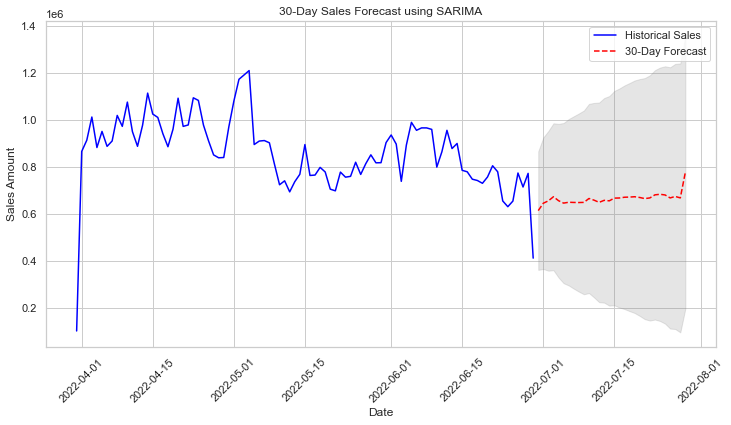

In [51]:
daily_sales = df.groupby('Date')['Amount'].sum()

model = SARIMAX(daily_sales, 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 30),  
                enforce_stationarity=False, 
                enforce_invertibility=False)


model_fit = model.fit(disp=False)

forecast_steps = 30  
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=daily_sales.index[-1], periods=forecast_steps + 1, freq='D')[1:]

plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales.values, label='Historical Sales', color='blue')
plt.plot(forecast_index, forecast.predicted_mean, label='30-Day Forecast', color='red', linestyle='--')
plt.fill_between(forecast_index, 
                 forecast.conf_int().iloc[:, 0], 
                 forecast.conf_int().iloc[:, 1], 
                 color='gray', alpha=0.2) 
plt.title('30-Day Sales Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**The red dashed line is the 30-day sales forecast generated using the SARIMA model, predicting a slight upward trend in sales for the next 30 days.**

##### **Monthly sales for the Top 3 categories**

In [72]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month_name()
order_months = ['March', 'April', 'May', 'June']
df['Month'] = pd.Categorical(df['Month'], categories=order_months, ordered=True)

unique_categories = df['Category'].unique()[:3]

for category in unique_categories:
    category_data = df[df['Category'] == category]
    
    grouped = (
        category_data.groupby(['Category', 'Month'])['Amount']
        .sum()
        .reset_index()
        .rename(columns={'Amount': 'Total Sales'})
    )
    
    grouped['Total Sales'] = grouped['Total Sales'].apply(lambda x: f"{x:,.0f}")
    
    styled_table = apply_table_style(grouped)
    
    print(f"Table for Category: {category}")
    display(styled_table)
    print("\n")

Table for Category: Set


,Category,Month,Total Sales
0,Set,March,"53,884"
1,Set,April,"15,506,676"
2,Set,May,"12,643,698"
3,Set,June,"10,999,866"




Table for Category: kurta


,Category,Month,Total Sales
0,kurta,March,"34,257"
1,kurta,April,"8,017,145"
2,kurta,May,"6,660,577"
3,kurta,June,"6,587,568"




Table for Category: Western Dress


,Category,Month,Total Sales
0,Western Dress,March,"7,653"
1,Western Dress,April,"2,927,781"
2,Western Dress,May,"4,381,304"
3,Western Dress,June,"3,899,334"


#### **Month-over-Month Sales Growth**

Month-over-Month Growth:
Month
March             NaN
April    28261.149111
May         -9.058074
June       -10.678779
Name: Amount, dtype: float64



 Achieved a 28261.15% sales growth in April! 



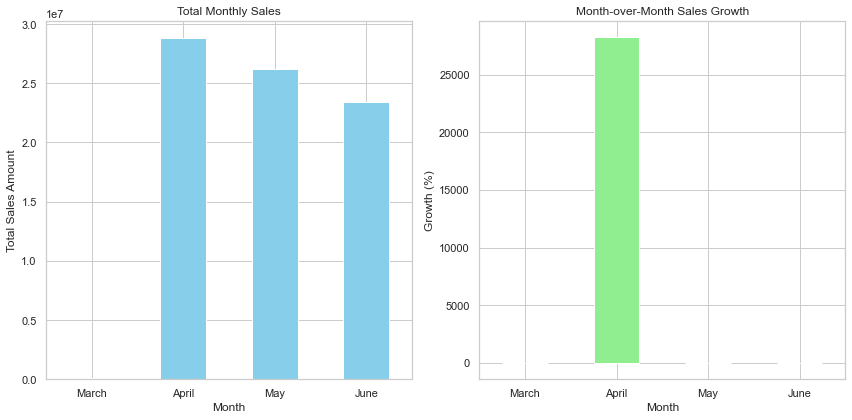

In [53]:
monthly_sales = df.groupby('Month')['Amount'].sum()
monthly_growth = monthly_sales.pct_change() * 100
monthly_sales = df.groupby('Month')['Amount'].sum()
monthly_growth = monthly_sales.pct_change() * 100
print("Month-over-Month Growth:")
print(monthly_growth)

monthly_sales = df.groupby('Month')['Amount'].sum()
monthly_growth = monthly_sales.pct_change() * 100
best_growth_month = monthly_growth.idxmax()
best_growth_percentage = monthly_growth.max()

init(autoreset=True)
message = f" Achieved a {best_growth_percentage:.2f}% sales growth in {best_growth_month}! "
print("\n" + "="*60)
print(f"{Style.BRIGHT}{Fore.CYAN}{message}")
print("="*60 + "\n")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
monthly_sales.plot(kind='bar', color='skyblue')
plt.title('Total Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
monthly_growth.plot(kind='bar', color='lightgreen')
plt.title('Month-over-Month Sales Growth')
plt.xlabel('Month')
plt.ylabel('Growth (%)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
category_sales = df.groupby(['Month', 'Category'])['Amount'].sum().unstack()

category_growth_mom = category_sales.pct_change(axis='columns') * 100
category_growth_mom.replace([np.inf, -np.inf], np.nan, inplace=True)
category_growth_mom.fillna(0, inplace=True)

top_categories = category_sales.sum(axis=0).nlargest(5).index

top_category_growth = category_growth_mom[top_categories]

styled_table = apply_table_style(top_category_growth)

print("\nMonth-over-Month Sales Growth (%) for Top 5 Categories:")
display(styled_table)


Month-over-Month Sales Growth (%) for Top 5 Categories:


Category,Set,kurta,Western Dress,Top,Ethnic Dress
Month,,,,,
March,0.000000,347.606386,69.658169,-91.628313,0.000000
April,27762.022624,173.830140,60.699896,-88.250910,0.000000
May,30339.882566,52.022685,119.547439,-84.216587,0.000000
June,41033.450204,68.940829,155.563196,-86.129096,26824.554098


**The results indicate that the "Set" category was the top performer, showing substantial growth throughout the period. The "Kurta" and "Western Dress" categories also demonstrated consistent growth. The "Top" category experienced a decline, while the "Ethnic Dress" category saw growth only in June.**

**The Date when Sales were at their maximum**

In [75]:
max_sales_date = daily_sales.idxmax()
max_sales_amount = daily_sales.max()
min_sales_date = daily_sales.idxmin()
min_sales_amount = daily_sales.min()

results = [
    ['Date of Maximum Sales', max_sales_date, 'Maximum Sales Amount', f'{max_sales_amount:,.2f}'],
    ['Date of Minimum Sales', min_sales_date, 'Minimum Sales Amount', f'{min_sales_amount:,.2f}']
]

styled_table = apply_table_style(pd.DataFrame(results, columns=["Description", "Date", "Description", "Amount"]))

display(styled_table)

,Description,Date,Description,Amount
0,Date of Maximum Sales,2022-05-04 00:00:00,Maximum Sales Amount,"1,209,364.17"
1,Date of Minimum Sales,2022-03-31 00:00:00,Minimum Sales Amount,"101,683.85"


**As expected, the minimum sales were at the end of March, and the maximum sales were at the start of April.**

#### **Top Regions by Sales: Identifying the regions with the highest sales amounts**

,Region,Sales Amount,Sales Percentage
0,MAHARASHTRA,"13,335,534.14",16.97%
1,KARNATAKA,"10,481,114.37",13.34%
2,TELANGANA,"6,916,615.65",8.80%
3,UTTAR PRADESH,"6,816,642.08",8.67%
4,TAMIL NADU,"6,515,650.11",8.29%
5,DELHI,"4,235,215.97",5.39%
6,KERALA,"3,830,227.58",4.87%
7,WEST BENGAL,"3,507,880.44",4.46%
8,ANDHRA PRADESH,"3,219,831.72",4.10%
9,HARYANA,"2,882,092.99",3.67%



78.56% of total sales are generated from the top 10 regions.


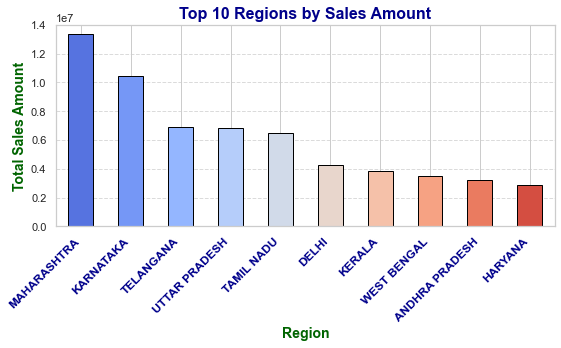

In [76]:
total_sales = data['Amount'].sum()
region_sales = data.groupby('ship-state')['Amount'].sum().sort_values(ascending=False)

top_10_regions = region_sales.head(10)
top_10_regions_percentage = (top_10_regions / total_sales) * 100

top_10_table = pd.DataFrame({
    'Region': top_10_regions.index,
    'Sales Amount': top_10_regions.values,
    'Sales Percentage': top_10_regions_percentage.values
})

top_10_table['Sales Amount'] = top_10_table['Sales Amount'].apply(lambda x: f'{x:,.2f}')
top_10_table['Sales Percentage'] = top_10_table['Sales Percentage'].apply(lambda x: f'{x:,.2f}%')

styled_table = apply_table_style(top_10_table)

display(styled_table)

total_top_10_percentage = top_10_regions_percentage.sum()
print(f"\n{total_top_10_percentage:.2f}% of total sales are generated from the top 10 regions.")

sns.set(style="whitegrid")

region_sales = data.groupby('ship-state')['Amount'].sum().sort_values(ascending=False)
top_regions = region_sales.head(10)

plt.figure(figsize=(8, 5))  
ax = top_regions.plot(kind='bar', color=sns.color_palette("coolwarm", len(top_regions)), edgecolor='black')

plt.title('Top 10 Regions by Sales Amount', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Region', fontsize=14, fontweight='bold', color='darkgreen')
plt.ylabel('Total Sales Amount', fontsize=14, fontweight='bold', color='darkgreen')

plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='bold', color='darkblue')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### **Analyzing whether different shipping options impact sales and customer satisfaction**

,ship-service-level,Total Sales,Total Orders,Avg Order Value
0,Expedited,54285183.000000,88615,612.595870
1,Standard,24307495.300000,40360,602.266980


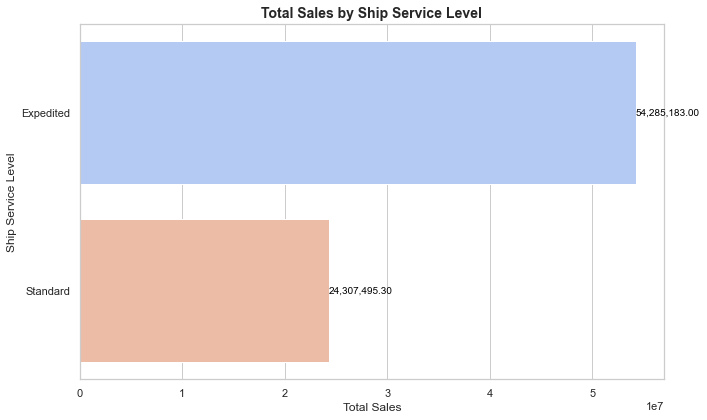

In [77]:
grouped_data = df.groupby('ship-service-level')

metrics_df = grouped_data.agg({
    'Amount': 'sum',         
    'Order ID': 'count'     
}).rename(columns={
    'Amount': 'Total Sales',
    'Order ID': 'Total Orders'
})

metrics_df['Avg Order Value'] = metrics_df['Total Sales'] / metrics_df['Total Orders']
metrics_df = metrics_df.reset_index()
metrics_df_sorted = metrics_df.sort_values(by='Total Sales', ascending=False)

styled_table = apply_table_style(metrics_df_sorted)
display(styled_table)

sns.set_theme(style="whitegrid")  
plt.figure(figsize=(10, 6))
colors = sns.color_palette("coolwarm", len(metrics_df_sorted))  

sns.barplot(
    x='Total Sales',
    y='ship-service-level',
    data=metrics_df_sorted,
    palette=colors
)

plt.title("Total Sales by Ship Service Level", fontsize=14, fontweight='bold')
plt.xlabel("Total Sales", fontsize=12)
plt.ylabel("Ship Service Level", fontsize=12)

for index, value in enumerate(metrics_df_sorted['Total Sales']):
    plt.text(value, index, f'{value:,.2f}', va='center', ha='left', fontsize=10, color='black')

plt.tight_layout()
plt.show()


* **So the expedited generated more revenue than the standard overall mainly due to the larger number of orders**

In [58]:
courier_status_counts = df['Courier Status'].value_counts(normalize=True) * 100

print("Courier Status Distribution (%):")
print(courier_status_counts)

Courier Status Distribution (%):
Shipped      84.890095
not known     5.328164
Unshipped     5.180074
Cancelled     4.601667
Name: Courier Status, dtype: float64


**Around 85% of courier status orders were successfully shipped**

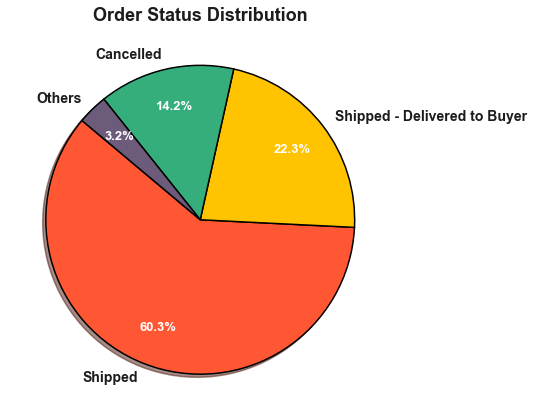

In [59]:
status_counts = df['Status'].value_counts()
top_statuses = ['Shipped', 'Shipped - Delivered to Buyer', 'Cancelled']
status_counts_updated = status_counts.copy()
status_counts_updated['Others'] = status_counts[~status_counts.index.isin(top_statuses)].sum()
status_counts_updated = status_counts_updated[top_statuses + ['Others']]

colors = ['#FF5733', '#FFC300', '#36AE7C', '#6C5B7B'] 
plt.style.use('seaborn-v0_8-darkgrid') 

fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts, autotexts = ax.pie(
    status_counts_updated,
    labels=status_counts_updated.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},  
    pctdistance=0.75, 
    shadow=True 
)

for text in texts:
    text.set_color('#1C1C1C')  
    text.set_fontsize(14)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_color('#FFFFFF') 
    autotext.set_fontsize(13)
    autotext.set_fontweight('bold')


ax.set_title(' Order Status Distribution ', fontsize=18, fontweight='bold', color='#1C1C1C')

plt.tight_layout()
plt.show()

In [60]:
status_sales = df.groupby('Status')['Amount'].sum()
cancelled_sales_percentage = (status_sales.get('Cancelled', 0) / status_sales.sum()) * 100

print(f"Sales were reduced by {cancelled_sales_percentage:.2f}% due to cancelled orders. Focus on improving order fulfillment to reduce cancellations.")

Sales were reduced by 8.80% due to cancelled orders. Focus on improving order fulfillment to reduce cancellations.


╒══════════════╤════════════════════╤═════════════════════════╕
│  Fulfilment  │  Success Rate (%)  │  Cancellation Rate (%)  │
╞══════════════╪════════════════════╪═════════════════════════╡
│    Amazon    │       86.74%       │         12.79%          │
├──────────────┼────────────────────┼─────────────────────────┤
│   Merchant   │       75.72%       │         17.47%          │
╘══════════════╧════════════════════╧═════════════════════════╛


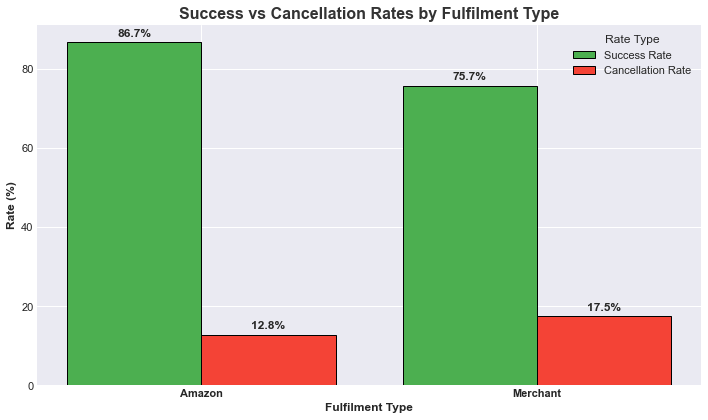

In [61]:
successful_statuses = ['Shipped', 'Shipped - Delivered to Buyer', 'Shipped - Picked Up']

fulfillment_group = df.groupby('Fulfilment')['Status'].value_counts(normalize=True).unstack().fillna(0) * 100

amazon_success = fulfillment_group.loc['Amazon', successful_statuses].sum()
amazon_cancel = fulfillment_group.loc['Amazon', 'Cancelled']
merchant_success = fulfillment_group.loc['Merchant', successful_statuses].sum()
merchant_cancel = fulfillment_group.loc['Merchant', 'Cancelled']

results = [
    ["Amazon", f"{amazon_success:.2f}%", f"{amazon_cancel:.2f}%"],
    ["Merchant", f"{merchant_success:.2f}%", f"{merchant_cancel:.2f}%"]
]

headers = ["Fulfilment", "Success Rate (%)", "Cancellation Rate (%)"]
table = tabulate(results, headers=headers, tablefmt="fancy_grid", stralign="center")
print(table)

fulfillment_rates = {
    'Success': [amazon_success, merchant_success],
    'Cancellation': [amazon_cancel, merchant_cancel]
}
fulfillment_labels = ['Amazon', 'Merchant']

x = range(len(fulfillment_labels))

plt.figure(figsize=(10, 6))
plt.bar(x, fulfillment_rates['Success'], width=0.4, label='Success Rate', color='#4CAF50', edgecolor='black')
plt.bar([i + 0.4 for i in x], fulfillment_rates['Cancellation'], width=0.4, label='Cancellation Rate', color='#F44336', edgecolor='black')

plt.title('Success vs Cancellation Rates by Fulfilment Type', fontsize=16, fontweight='bold', color='#333333')
plt.xlabel('Fulfilment Type', fontsize=12, fontweight='bold')
plt.ylabel('Rate (%)', fontsize=12, fontweight='bold')
plt.xticks([i + 0.2 for i in x], fulfillment_labels, fontsize=11, fontweight='bold')
plt.yticks(fontsize=11)
plt.legend(title='Rate Type', fontsize=11, title_fontsize=12)

for i, v in enumerate(fulfillment_rates['Success']):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
for i, v in enumerate(fulfillment_rates['Cancellation']):
    plt.text(i + 0.4, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


**Overall, Amazon performs better than Merchant**

Top 5 Postal Codes with Sales, City, and State:
  ship-postal-code    Sales    Contribution (%)  ship-city    ship-state
------------------  -------  ------------------  -----------  -------------
            201301   645309            0.82108   NOIDA        UTTAR PRADESH
            122001   453353            0.576838  GURUGRAM     HARYANA
            560068   388749            0.494638  BENGALURU    KARNATAKA
            560037   383603            0.488091  BENGALURU    KARNATAKA
            560076   352687            0.448753  BENGALURU    KARNATAKA


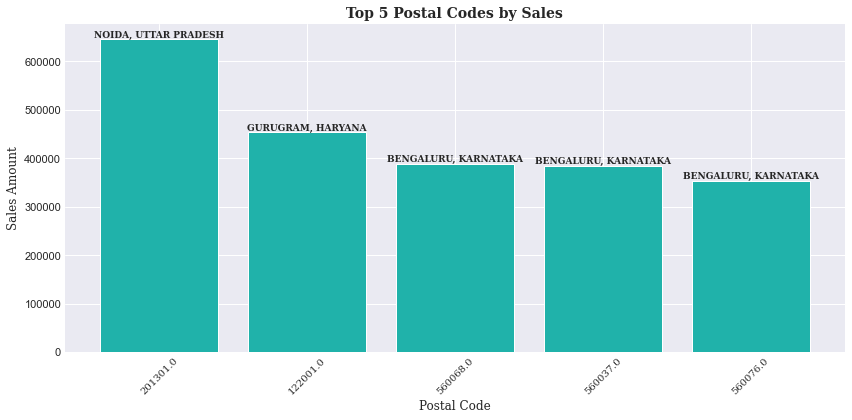

In [62]:
postal_sales = df.groupby('ship-postal-code')['Amount'].sum()

top_postal_sales = postal_sales.sort_values(ascending=False).head(5)

top_postal_info = df[df['ship-postal-code'].isin(top_postal_sales.index)][['ship-postal-code', 'ship-city', 'ship-state']]
top_postal_info = top_postal_info.drop_duplicates(subset=['ship-postal-code'])

top_postal_df = pd.DataFrame({
    'ship-postal-code': top_postal_sales.index,
    'Sales': top_postal_sales.values,
    'Contribution (%)': (top_postal_sales.values / df['Amount'].sum()) * 100
})
top_postal_df = top_postal_df.merge(top_postal_info, on='ship-postal-code', how='left')

print("Top 5 Postal Codes with Sales, City, and State:")
print(tabulate(top_postal_df, headers='keys', tablefmt='fancygrid', showindex=False))

plt.figure(figsize=(12, 6))
bars = plt.bar(top_postal_df['ship-postal-code'].astype(str), top_postal_df['Sales'], color='lightseagreen')
plt.title('Top 5 Postal Codes by Sales', fontsize=14, fontweight='bold', family='serif')
plt.xlabel('Postal Code', fontsize=12, family='serif')
plt.ylabel('Sales Amount', fontsize=12, family='serif')
plt.xticks(rotation=45, fontsize=10, family='serif')

for bar, (_, row) in zip(bars, top_postal_df.iterrows()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 500, 
             f"{row['ship-city']}, {row['ship-state']}", 
             ha='center', va='bottom', fontsize=9, fontweight='bold', family='serif', rotation=0)

plt.tight_layout()
plt.show()

### **Analyzing the sales data based on different product categories, size and quantity**

**Performing a statistical analysis to analyze distribution of sales deeply**

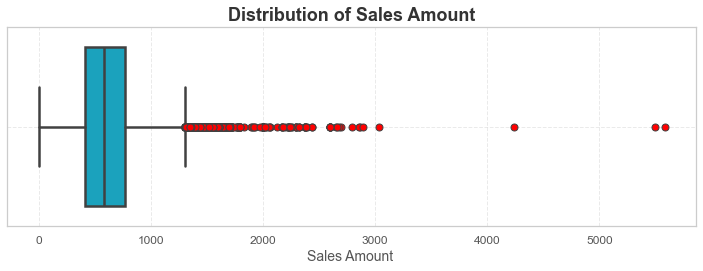

In [63]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(10, 4))

sns.boxplot(
    x=df['Amount'], 
    color="#00b4d8",  
    linewidth=2.5,   
    fliersize=6,      
    flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 7} 
)

plt.grid(True, linestyle="--", alpha=0.4)
plt.title('Distribution of Sales Amount', fontsize=18, weight='bold', color='#333333')
plt.xlabel('Sales Amount ', fontsize=14, color='#555555')
plt.xticks(fontsize=12, color='#555555')
plt.tight_layout()

plt.show()

**The distribution of sales amounts is skewed to the right. This means that most sales are relatively small, but there are a few very large sales that pull the distribution to the right, and to analyze them lets do a z score analysis**

In [64]:
df['z_score'] = zscore(df['Amount'])

outliers_zscore = df[df['z_score'].abs() > 3]

min_outlier = outliers_zscore.sort_values('Amount').iloc[0]

print("Outliers based on Z-score:")
print(outliers_zscore[['Amount', 'z_score']])

print("\n" + "="*60)
print(f" MINIMUM OUTLIER ")
print(f"Amount: {min_outlier['Amount']:.2f} | Z-score: {min_outlier['z_score']:.2f}")
print("="*60)

Outliers based on Z-score:
         Amount   z_score
index                    
265     2130.00  4.852900
324     1902.86  4.128014
349     1999.00  4.434831
647     2224.00  5.152888
803     1669.00  3.381682
...         ...       ...
125705  1603.00  3.171052
126145  1698.00  3.474232
126821  2598.00  6.346457
128343  1559.00  3.030632
128402  1556.00  3.021058

[436 rows x 2 columns]

 MINIMUM OUTLIER 
Amount: 1551.00 | Z-score: 3.01


In [78]:
high_sales_df = df[df['Amount'] > 1550]

category_sales_count = high_sales_df.groupby('Category').size().reset_index(name='Sales Count')

category_sales_count['Sales Count'] = category_sales_count['Sales Count'].apply(lambda x: f"{x:,}")

print(Fore.CYAN + Style.BRIGHT + "\nNumber of Sales Greater Than 1550 for Each Category:" + Style.RESET_ALL)

styled_table = apply_table_style(category_sales_count)
styled_table



Number of Sales Greater Than 1550 for Each Category:


,Category,Sales Count
0,Saree,2
1,Set,405
2,Top,3
3,Western Dress,15
4,kurta,11


**From these results, we see that Set category is generating the most sales from the most expensive items**

In [79]:
import pandas as pd

# Assuming df is your DataFrame
category_sales = df.groupby('Category').agg({'Qty': 'sum', 'Amount': 'sum'}).reset_index()

category_sales['Total Sales Volume'] = category_sales['Qty']
category_sales['Total Sales Amount'] = category_sales['Amount']

category_sales['Avg Sales Amount per item'] = category_sales['Total Sales Amount'] / category_sales['Total Sales Volume']

sorted_categories = category_sales[['Category', 'Total Sales Volume', 'Total Sales Amount', 'Avg Sales Amount per item']].sort_values(by='Total Sales Volume', ascending=True)

sorted_categories['Total Sales Amount'] = sorted_categories['Total Sales Amount'].apply(lambda x: f"{x:,.2f}")
sorted_categories['Total Sales Volume'] = sorted_categories['Total Sales Volume'].apply(lambda x: f"{x:,}")
sorted_categories['Avg Sales Amount per item'] = sorted_categories['Avg Sales Amount per item'].apply(lambda x: f"{x:,.2f}")

max_lengths = {
    'Category': max(sorted_categories['Category'].apply(len)),
    'Total Sales Volume': max(sorted_categories['Total Sales Volume'].apply(len)),
    'Total Sales Amount': max(sorted_categories['Total Sales Amount'].apply(len)),
    'Avg Sales Amount per item': max(sorted_categories['Avg Sales Amount per item'].apply(len))
}


styled_table = apply_table_style(sorted_categories)

styled_table


,Category,Total Sales Volume,Total Sales Amount,Avg Sales Amount per item
2,Dupatta,3,915.00,305.00
4,Saree,152,"123,933.76",815.35
1,Bottom,398,"150,667.98",378.56
0,Blouse,863,"458,408.18",531.18
3,Ethnic Dress,"1,053","791,217.66",751.39
6,Top,"9,903","5,347,792.30",540.02
7,Western Dress,"13,943","11,216,072.69",804.42
8,kurta,"45,045","21,299,546.70",472.85
5,Set,"45,289","39,204,124.03",865.64


* **The "Set" category dominates in terms of sales volume, total sales amount, and average price, suggesting high demand and premium pricing. "Western Dress" and "Kurta" also perform well. "Top" has high volume but lower average price. Similarly Saree has high pricing but low sales volume.**

* **Overall, Set category is the best performer in all dimensions.**

C:\Users\Admin\AppData\Local\Temp\ipykernel_14292\1011759462.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_category_sales = top_categories.append(pd.Series(others, index=['Others']))


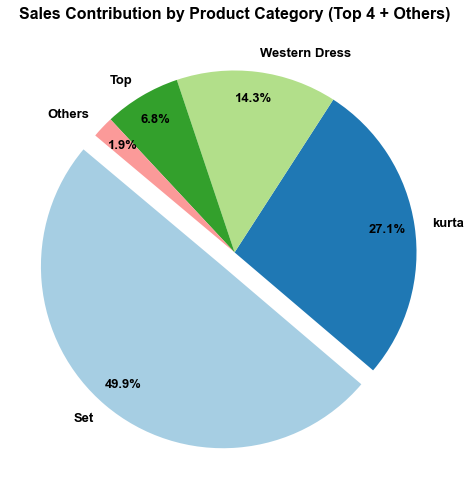

In [67]:
category_sales = df.groupby('Category')['Amount'].sum().sort_values(ascending=False)
top_categories = category_sales[:4]  
others = category_sales[4:].sum() 
final_category_sales = top_categories.append(pd.Series(others, index=['Others']))

plt.figure(figsize=(9, 7))

explode = [0.1 if category == 'Set' else 0 for category in final_category_sales.index]

plt.pie(final_category_sales, 
        labels=final_category_sales.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        explode=explode, 
        colors=plt.cm.Paired.colors,  
        textprops={'fontsize': 13, 'weight': 'bold', 'color': 'black'},  
        wedgeprops={'edgecolor': 'none', 'linewidth': 0},  
        shadow=False,  
        pctdistance=0.85)  

plt.title('Sales Contribution by Product Category (Top 4 + Others)', fontsize=16, weight='bold', color='black')
plt.tight_layout()  
plt.show()

##### **Analyzing Sales by Size and Quantity Sold**

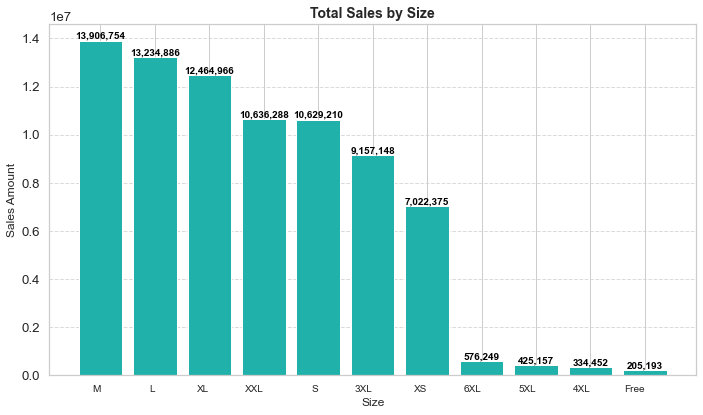

In [68]:
size_sales = df.groupby('Size')['Amount'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.bar(size_sales.index, size_sales.values, color='lightseagreen')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.title('Total Sales by Size', fontsize=14, fontweight='bold')
plt.xlabel('Size', fontsize=12)
plt.ylabel('Sales Amount', fontsize=12)
plt.xticks(rotation=0, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

**The graph shows that size "M" has the highest sales, followed by "L" and "XL". Sizes "S", "XXL" and "3XL" also have significant sales, while smaller and larger sizes have lower sales.**

In [80]:
category_size_sales = df.groupby(['Category', 'Size'])['Qty'].sum().reset_index()
top_sizes_by_category = category_size_sales.sort_values(['Category', 'Qty'], ascending=[True, False]).drop_duplicates('Category')

styled_table = apply_table_style(top_sizes_by_category)

styled_table

,Category,Size,Qty
0,Blouse,Free,211
8,Bottom,L,67
14,Dupatta,Free,3
19,Ethnic Dress,XL,173
22,Saree,Free,152
28,Set,M,8357
37,Top,XL,1734
41,Western Dress,L,2546
51,kurta,L,8043


**Free Size:** Blouses, Dupattas, and Sarees have high demand for free sizes.

**Large Size:** Bottoms, Western Dresses, and Kurtas have a strong preference for size L.

**Medium Size:** Sets have the highest demand for size M and also the most sold item.

**Extra-Large Size:** Ethnic Dresses and Tops have high demand for size XL.

In [70]:
# df.to_excel('sales_analysis.xlsx', index=False)